# Data Preparation and Exploration

In [2]:
!pip install pmdarima

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

In [4]:
# Load exchange rate data, parsing dates correctly and setting them as index
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], dayfirst=True)
df

,date,Ex_rate
0,1990-01-01,0.785500
1,1990-01-02,0.781800
2,1990-01-03,0.786700
3,1990-01-04,0.786000
4,1990-01-05,0.784900
...,...,...
7583,2010-10-06,0.718494
7584,2010-10-07,0.721839
7585,2010-10-08,0.723197
7586,2010-10-09,0.720825


In [5]:
 # # Set daily frequency to maintain consistency
df.set_index('date', inplace=True)
df = df.asfreq('D') 
df

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


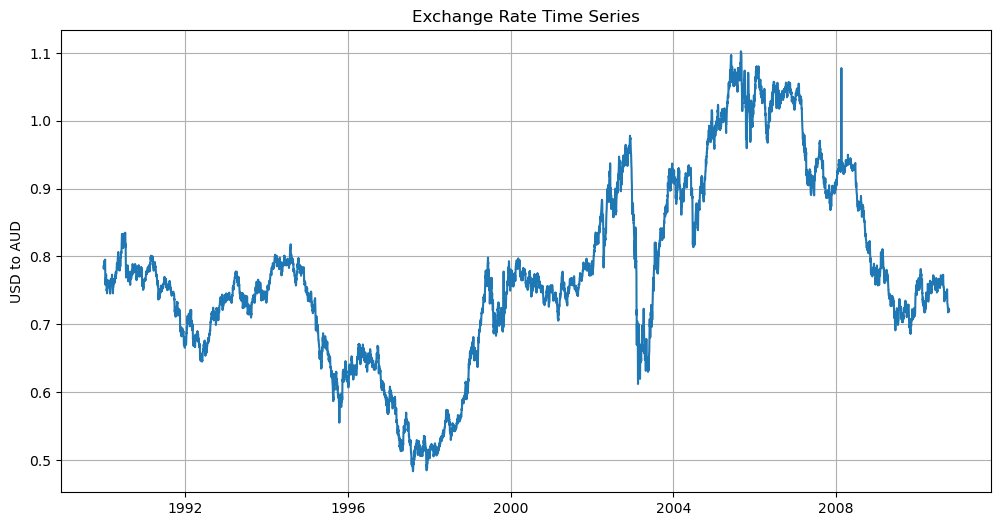

In [6]:
# Initial Exploration
# Plot the time series data to visualize trends
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'])
plt.title('Exchange Rate Time Series')
plt.ylabel('USD to AUD')
plt.grid(True)
plt.show()

In [7]:
# 3. Data Preprocessing
# Check for missing values in the dataset
print(f"Missing values: {df.isnull().sum()}")

# Handle missing values using linear interpolation to fill gaps
# This helps maintain continuity in the time series
df['Ex_rate'] = df['Ex_rate'].interpolate(method='linear')


Missing values: Ex_rate    0
dtype: int64


# Model Building - ARIMA

In [9]:
# Parameter Selection
# Check stationarity using the Augmented Dickey-Fuller (ADF) test
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.664994180738073
p-value: 0.44923273535983155


In [10]:
# If the series is not stationary, apply differencing to make it stationary
if result[1] > 0.05:
    df['diff'] = df['Ex_rate'].diff().dropna()  # First-order differencing
    
    # Re-run the ADF test on differenced data
    result = adfuller(df['diff'].dropna())
    print(f'Differenced ADF Statistic: {result[0]}')
    print(f'Differenced p-value: {result[1]}')



Differenced ADF Statistic: -99.39343120118626
Differenced p-value: 0.0


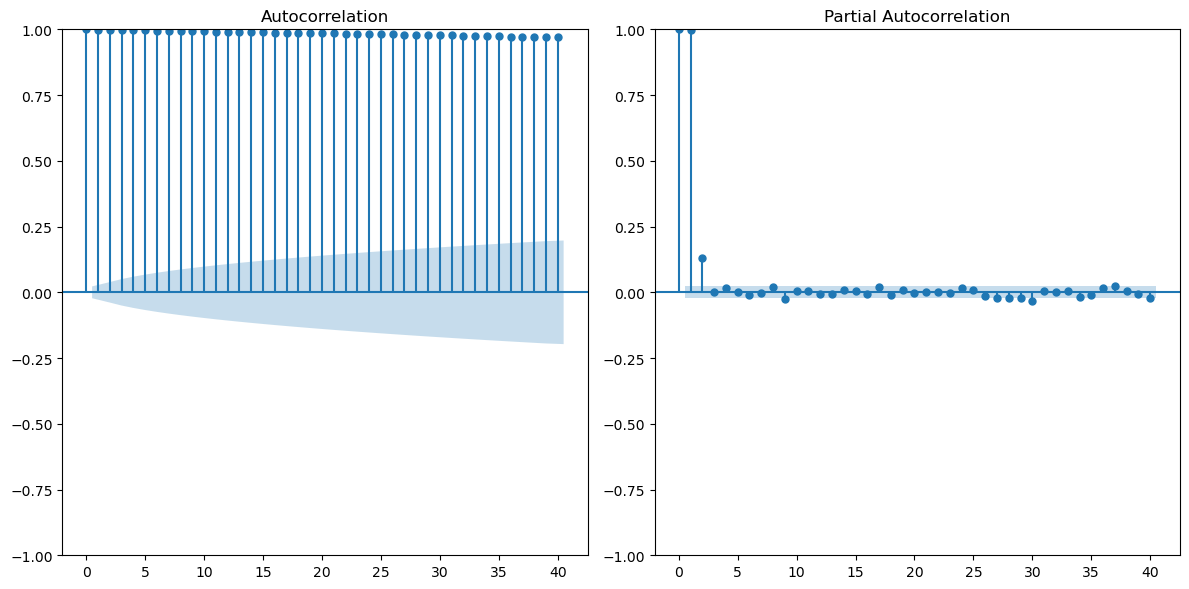

In [11]:
# Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12,6))
plot_acf(df['Ex_rate'].dropna(), lags=40, ax=plt.subplot(121))
plot_pacf(df['Ex_rate'].dropna(), lags=40, ax=plt.subplot(122))
plt.tight_layout()
plt.show()



In [12]:
# Use auto_arima to determine the best ARIMA parameters automatically
auto_model = auto_arima(df['Ex_rate'], seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-56098.154, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55972.211, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56102.338, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56100.772, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-55974.195, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-56100.340, Time=1.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56100.341, Time=1.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-56098.328, Time=2.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-56104.319, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-56102.321, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-56102.322, Time=1.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-56102.753, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-56100.316, Time=1.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 13.442 sec

In [13]:
# Model Fitting
# Fit an ARIMA model using the best parameters selected from auto_arima
best_order = auto_model.order  # Extract optimal order
model_arima = ARIMA(df['Ex_rate'], order=best_order)
results_arima = model_arima.fit()


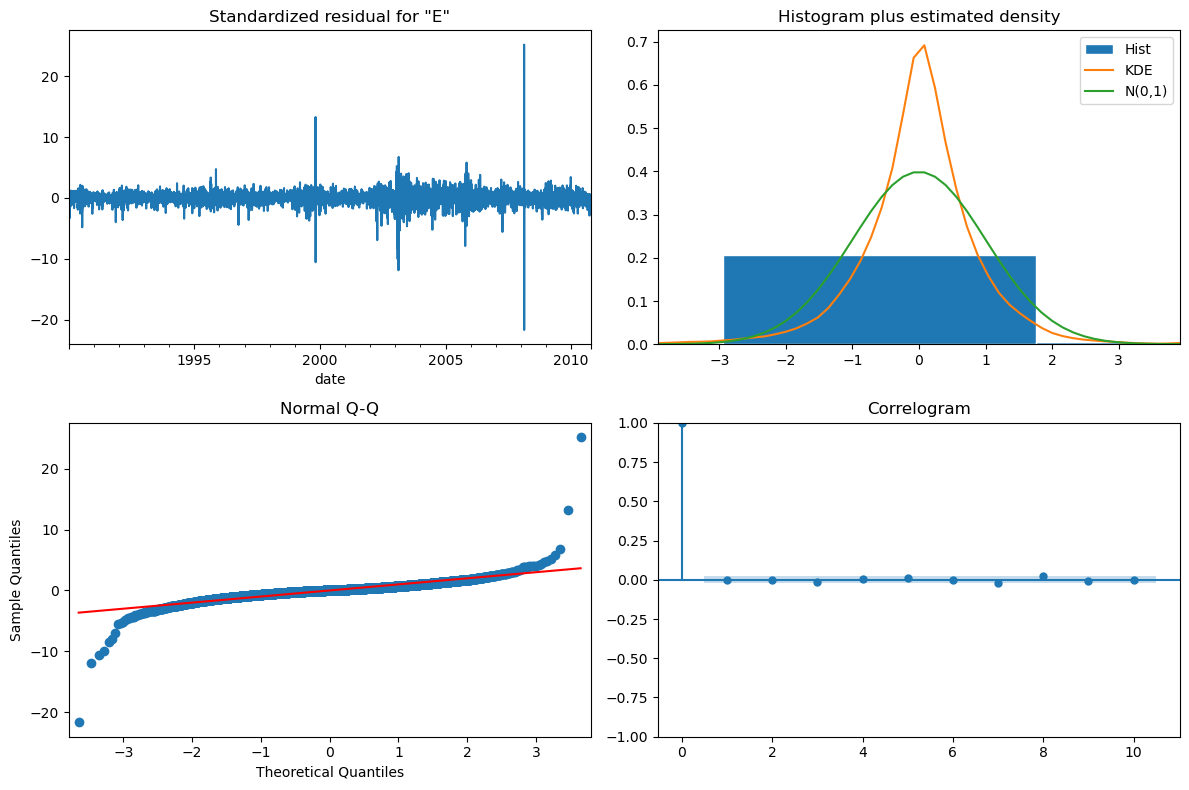

In [14]:
# Diagnostics
# Generate diagnostic plots to assess residuals
results_arima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()


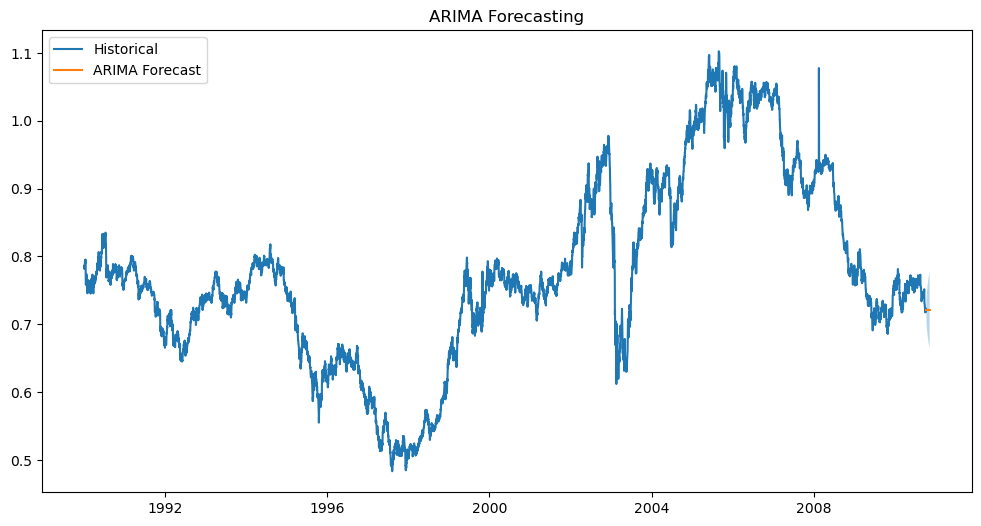

In [15]:
# Forecasting
forecast_steps = 30  # Number of days to forecast
forecast = results_arima.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Plot historical data and forecasted values
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='ARIMA Forecast')
plt.fill_between(forecast_index, 
                 forecast.conf_int()['lower Ex_rate'],
                 forecast.conf_int()['upper Ex_rate'],
                 alpha=0.3)
plt.title('ARIMA Forecasting')
plt.legend()
plt.show()

# Model Building - Exponential Smoothing

In [17]:
# Model Selection and Fitting
# Fit an Exponential Smoothing model with both trend and seasonality
model_es = ExponentialSmoothing(df['Ex_rate'],
                                trend='add',
                                seasonal='add', 
                                seasonal_periods=30).fit()


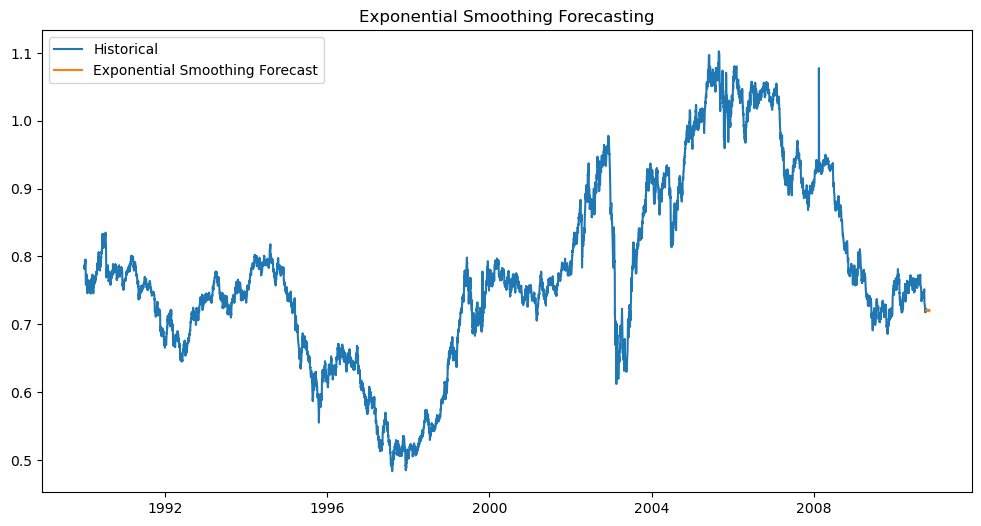

In [18]:
# Forecasting using Exponential Smoothing
forecast_es = model_es.forecast(forecast_steps)

# Plot historical data along with the Exponential Smoothing forecast
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_es.index, forecast_es, label='Exponential Smoothing Forecast')
plt.title('Exponential Smoothing Forecasting')
plt.legend()
plt.show()

# Evaluation and Comparison

In [20]:
# Split data into training (70%) and testing (30%) sets
train_size = int(len(df) * 0.7)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

# Refit ARIMA model on training data and make predictions
model_arima_train = ARIMA(train, order=best_order).fit()
forecast_arima = model_arima_train.get_forecast(steps=len(test)).predicted_mean

# Refit Exponential Smoothing model on training data and make predictions
model_es_train = ExponentialSmoothing(train,
                                      trend='add',
                                      seasonal='add',
                                      seasonal_periods=30).fit()
forecast_es = model_es_train.forecast(len(test))


In [21]:
# Function to compute evaluation metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)  # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(actual, forecast))  # Root Mean Squared Error
    mape = np.mean(np.abs((actual - forecast)/actual)) * 100  # Mean Absolute Percentage Error
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Compute error metrics for both models
arima_metrics = calculate_metrics(test, forecast_arima)
es_metrics = calculate_metrics(test, forecast_es)


In [22]:
# Print evaluation results
print("\nARIMA Metrics:")
print(pd.Series(arima_metrics))
print("\nExponential Smoothing Metrics:")
print(pd.Series(es_metrics))



ARIMA Metrics:
MAE      0.119045
RMSE     0.132168
MAPE    12.996806
dtype: float64

Exponential Smoothing Metrics:
MAE      0.122290
RMSE     0.136051
MAPE    13.721278
dtype: float64


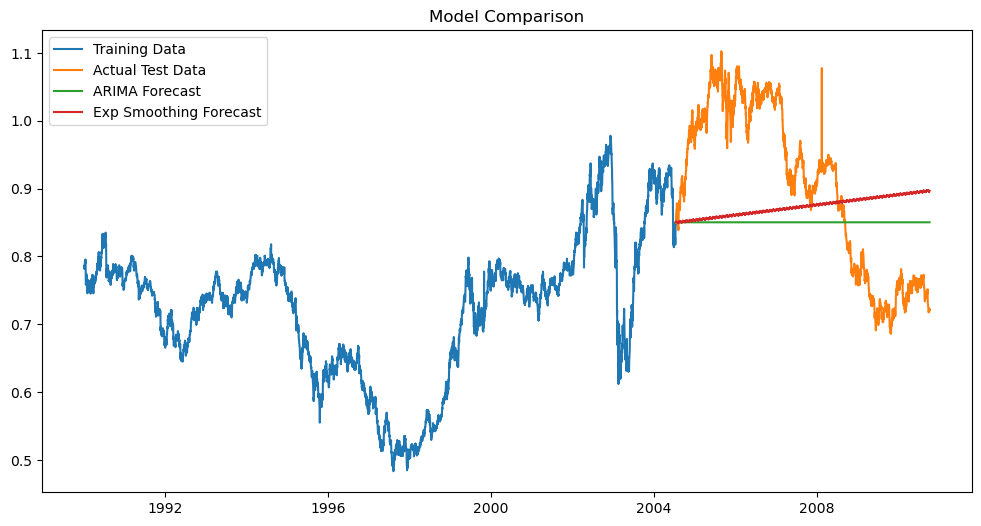

In [23]:
# Comparative plot of actual vs predicted values for both models
plt.figure(figsize=(12,6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.plot(forecast_es, label='Exp Smoothing Forecast')
plt.title('Model Comparison')
plt.legend()
plt.show()